In [1]:
import pickle as pkl
import numpy as np
import os
from typing import Dict
from matplotlib import pyplot as plt
from mrl.util import normalize_diffs
from mpl_toolkits import mplot3d

In [2]:
os.chdir('/home/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/inference/2022-03-25:20:23:51')
os.getcwd()

'/data/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/inference/2022-03-25:20:23:51'

In [3]:
reward_samples = np.load('trials/reward_sample.npy')
likelihoods: Dict[str, np.ndarray] = pkl.load(open('trials/trial-0/likelihood.pkl', 'rb'))
true_reward = np.load('trials/true_reward.npy')
mean_rewards = pkl.load(open('trials/trial-0/mean_reward.pkl', 'rb'))

In [4]:
print(likelihoods.keys())
print(likelihoods['traj'].shape)

dict_keys(['state', 'traj', 'joint'])
(100001, 1000)


In [5]:
max_index = np.argmax(likelihoods['traj'][:,-1])
max_likelihood = likelihoods['traj'][max_index,-1]
map_reward = reward_samples[max_index]

mean_reward = mean_rewards['traj'][-1]
print(f"""True reward={true_reward}
MAP reward={map_reward} with likelihood {max_likelihood}
Mean reward={mean_reward}""")

True reward=[ 0.70359754 -0.70359754 -0.07035975 -0.07035975]
MAP reward=[ 0.70359754 -0.70359754 -0.07035975 -0.07035975] with likelihood 0.9999999998164255
Mean reward=[ 0.70359754 -0.70359754 -0.07035975 -0.07035975]


In [6]:
top_ten_indices = np.argsort(likelihoods['traj'][:,-1])[-10:]
top_ten_likelihoods = likelihoods['traj'][top_ten_indices,-1]
top_ten_rewards = reward_samples[top_ten_indices]
for reward, likelihood in zip(top_ten_rewards, top_ten_likelihoods):
    print(f"reward={reward} with likelihood {likelihood}")

reward=[ 0.64177598 -0.7517535  -0.09917527 -0.11469321] with likelihood 1.495622736993175e-25
reward=[ 0.2902935  -0.95395357 -0.04881743 -0.05761181] with likelihood 2.0465992627204547e-25
reward=[ 0.96277426 -0.25020606 -0.07651368 -0.06788456] with likelihood 2.4303726589642683e-23
reward=[ 0.96721224 -0.23315418 -0.07270785 -0.06966476] with likelihood 3.6448831383148506e-20
reward=[ 0.32412101 -0.94216387 -0.06161636 -0.0589597 ] with likelihood 2.207017071647475e-15
reward=[ 0.81178315 -0.56855771 -0.09228088 -0.0960963 ] with likelihood 2.8743745462116905e-15
reward=[ 0.94603185 -0.31089204 -0.06776689 -0.06146152] with likelihood 1.1535943369848975e-13
reward=[ 0.67716678 -0.72424642 -0.0858927  -0.09764594] with likelihood 2.1116030325948554e-13
reward=[ 0.89086906 -0.44041554 -0.07784296 -0.07954209] with likelihood 1.8324287942148636e-10
reward=[ 0.70359754 -0.70359754 -0.07035975 -0.07035975] with likelihood 0.9999999998164255


So we're not even consistently right on the sign of the first and sceond traj_features. Let's look at our difference vectors.

In [8]:
temps = pkl.load(open('trials/temp.pkl', 'rb'))
traj_features = np.load(f"/home/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/prefs/traj/{temps['traj']}/dedup/norm-sum-length/length-10/prefs.features.npy")
state_features = np.load(f"/home/joschnei/multimodal-reward-learning/data/miner/near-original-reward/7/prefs/state/{temps['state']}/dedup/norm-sum-length/length-10/prefs.features.npy")

In [9]:
traj_features.shape

(1, 1000, 2, 4)

In [11]:
def plot_feature_diffs(features: np.ndarray, title: str):
    diffs = features[:,0] - features[:,1]
    diffs = normalize_diffs(features, mode='sum-length')
    oriented_diffs = (diffs.T * ((diffs @ true_reward > 0) * 2 - 1)).T
    assert np.all(oriented_diffs @ true_reward >= 0)
    for i in range(oriented_diffs.shape[-1]):
        feature = oriented_diffs[:,i]
        print(f"mean={np.mean(feature)}, std={np.std(feature)}, min={np.min(feature)}, max={np.max(feature)} gt={true_reward[i]}")
        plt.hist(feature)
        plt.title(title)
        plt.show()
        plt.close()

mean=0.0010769823165759412, std=0.0023638378803962174, min=-0.008578340444829342, max=0.010123108244871774 gt=0.7035975447302919


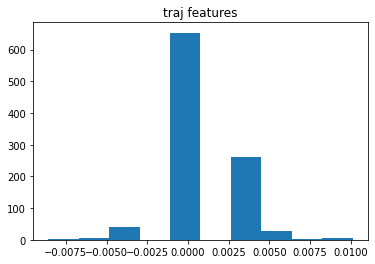

mean=0.0006653113092633954, std=0.003026067396288532, min=-0.015774203368939498, max=0.012145637599415293 gt=-0.7035975447302919


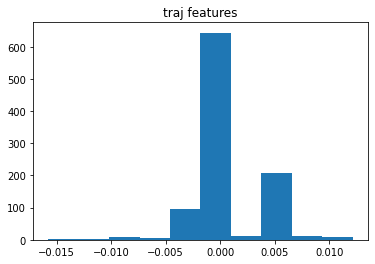

mean=-0.1158897134413092, std=0.11459599210927567, min=-0.5849441710726218, max=0.2024398521206752 gt=-0.0703597544730292


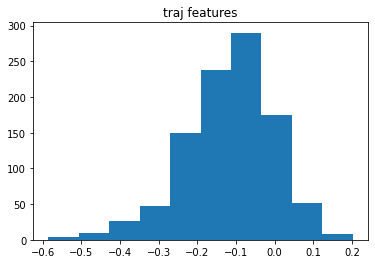

mean=-0.056115129065672925, std=0.12714056773890045, min=-0.657860542647476, max=0.1675661028824413 gt=-0.0703597544730292


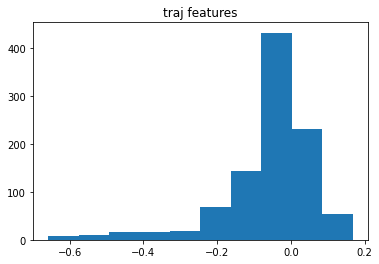

In [12]:
plot_feature_diffs(traj_features[0], 'traj features')

The signal on these first two features is almost nonexistant. The sign on the first feature is wrong, on avegerage. We might be able to get the magnitudes to be larger with a different normalization scheme, but we can't fix the sign.

mean=0.015112326624195937, std=0.025128859291029964, min=-0.050480580495509325, max=0.06000376222910986 gt=0.7035975447302919


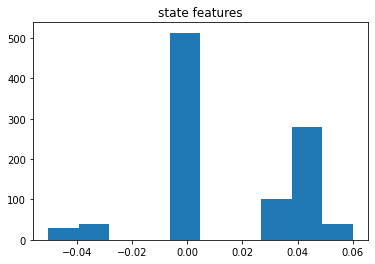

mean=-0.010816328099453657, std=0.02773757279322832, min=-0.06499983156847709, max=0.058770540465852075 gt=-0.7035975447302919


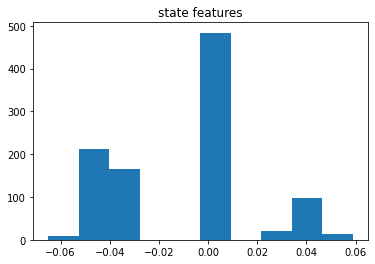

mean=-0.1179540189291639, std=0.2538622296515354, min=-0.6520638173578358, max=0.48810310924383216 gt=-0.0703597544730292


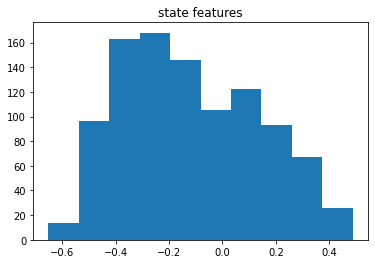

mean=-0.02699938225361898, std=0.1473093573423479, min=-0.420026335603769, max=0.3754102880690571 gt=-0.0703597544730292


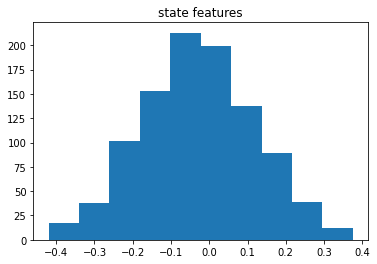

In [13]:
plot_feature_diffs(state_features[0], 'state features')

In [ ]:
three_state_features = state_features[0,:,:,:3]
three_traj_features = traj_features[0,:,:,:3]

three_state_diffs = normalize_diffs(three_state_features, mode='sum-length')
three_traj_diffs = normalize_diffs(three_traj_features, mode='sum-length')

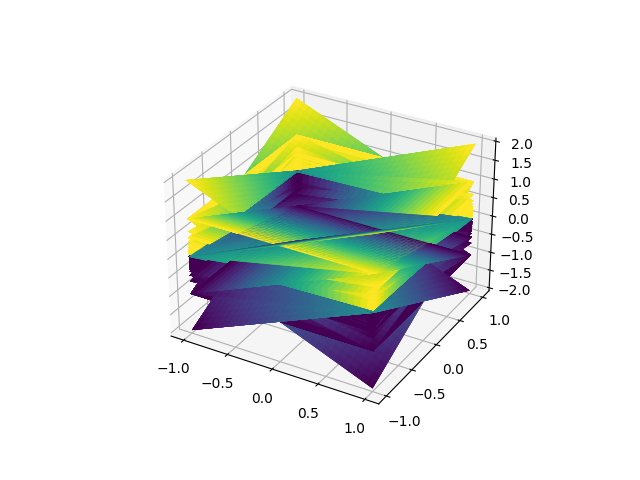

In [ ]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')
x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 30)
X, Y = np.meshgrid(x, y)

# TODO: Deduplicate, 
def plot_normal(normal: np.ndarray, ax) -> None:
	# normal[0] * x + normal[1] * y + normal[2] * z = 0
	# z = -(normal[0] * x + normal[1] * y) / normal[2]
	if normal[2] == 0:
		# TODO: How do I plot vertical surfaces?
		return
	Z = -(normal[0] * X + normal[1] * Y) / normal[2] 
	ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# interesting_normals = three_state_diffs[np.any(three_state_diffs[:,:2] != 0, axis=1)]
for normal in three_state_diffs:
	plot_normal(normal, ax)